In [92]:
import copy
from datetime import datetime
import os
import pickle
import sys
import time
sys.path.append('/home/diego/python/generative-glm/experiments/')

import h5py
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
from scipy.io import loadmat
import seaborn as sns
import torch
from torch.optim import Adagrad, Adam, RMSprop, SGD
from torch.optim.lr_scheduler import ExponentialLR

from experiments.utils.plot import plot_errorbar
from gglm.glm.mbmmdglm import MBMMDGLM
from gglm.glm.torchglm import TorchGLM
from gglm.kernels import phi_autocor_history
from gglm.metrics import bernoulli_log_likelihood_poisson_process, time_rescale_transform
from gglm.utils import shift_array
from kernel.fun import KernelFun
from kernel.rect import KernelRect
from kernel.values import KernelBasisValues
import myplt
from signals import raw_autocorrelation
from sptr.sptr import SpikeTrain
from utils import plot_layout_fig3

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1', l2='C9')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
server_name = os.uname()[1]
print(server_name)
from IPython.display import Javascript
Javascript('document.title="{}"'.format(server_name))

cypress


<IPython.core.display.Javascript object>

In [94]:
# path = "/home/diego/python/generative-glm/cool_stuff/human_ctx.h5"
path = "./human_ctx.h5"
f = loadmat(path)

arg_spikes = (np.array(f['MC']['spikeTimes'][0][0], dtype=int), np.array(f['MC']['spikeIndices'][0][0], dtype=int) - 1)

dt = 1
t = np.arange(0, 10000, dt)
mask_spikes = np.zeros((len(t), 10), dtype=bool)
mask_spikes[arg_spikes] = True

n_train = 10
mask_spikes_train = mask_spikes[:, :n_train]
n_spk_train = np.sum(mask_spikes_train)
fr_train = np.mean(np.sum(mask_spikes_train, 0) / (t[-1] - t[0] + t[1]) * 1000)
nll_pois_proc_train = -bernoulli_log_likelihood_poisson_process(mask_spikes_train)
autocor_train = np.mean(raw_autocorrelation(mask_spikes_train, biased=True), 1)

argf_autocor = 200
padding = 100
bins = np.arange(0, 4600, 1)

st_train = SpikeTrain(t, mask_spikes_train)
isi_train = st_train.isi_distribution()
mean_isi_train = np.mean(isi_train)

conv_ker = KernelFun.gaussian_delta(20)
psth_d = np.mean(st_train.convolve(conv_ker), 1) * 1000

### kernels

1354.3242079770387


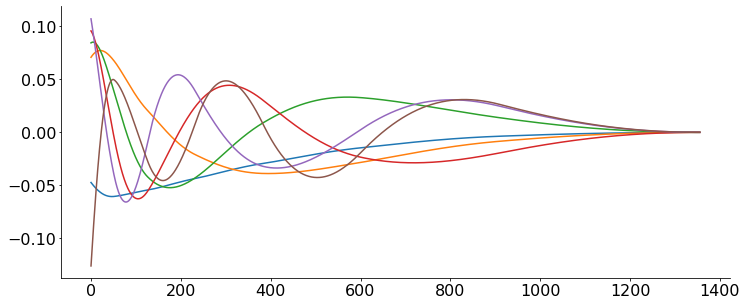

In [4]:
def raised_cosine(t, b, c, dc, a=1e0):
    basis = (1 + np.cos(np.maximum(-np.pi, np.minimum(a * (np.log(t + b) - c) * np.pi / dc / 2, np.pi)))) / 2
    basis = basis / np.sqrt(np.sum(basis**2, 0))
    u, s, v = np.linalg.svd(basis)
    basis = u[:, :basis.shape[1]]
    return basis

n = 6
last_peak = 600
b = last_peak / 5
peak0 = 0

yrnge = np.log(np.array([0, last_peak]) + b)
db = np.diff(yrnge) / (n - 1)
ctrs = np.arange(yrnge[0], yrnge[1] + db, db)
mxt = np.exp(yrnge[1] + 2 * db) - b # max time bin
print(mxt[-1])
t_ker = np.arange(0, mxt[-1] + dt, dt)

basis = raised_cosine(t_ker[:, None], b, ctrs[None, :], db)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(t_ker, basis)

## contents <a name="contents"></a>  

[ML](#ml)  
[L2](#l2)  
[MMD](#mmd)  
[paper_figure](#paper_figure)  

### ML <a name="ml"></a>  

In [95]:
def fun_metrics_ml(model, t, mask_spikes, X, n_batch_fr=None):
    T = st_train.t[-1] - st_train.t[0] + st_train.t[1]
    u_fr, r_fr, mask_spikes_fr = model.sample(st_train.t, shape=(n_batch_fr,))
    fr = np.sum(mask_spikes_fr, 0) / T * 1000
    mu_fr = np.mean(fr)
    return dict(mu_fr=mu_fr)

In [96]:
coefs = np.zeros(basis.shape[1])
eta0 = KernelBasisValues(basis.copy(), [0, basis.shape[0]], 1, coefs=coefs)

lr = 1e-1
num_epochs = 300
metrics_kwargs = dict(n_batch_fr=60)
n_metrics = 10

glm = TorchGLM(u0=-5, eta=eta0.copy())
optim = Adam(glm.parameters(), lr=lr)
loss_ml, metrics_ml = glm.train(st_train.t, st_train.mask, optim=optim, num_epochs=num_epochs, 
                                verbose=True, metrics=fun_metrics_ml, metrics_kwargs=metrics_kwargs, 
                                n_metrics=n_metrics)
loss_ml = np.array(loss_ml)
iterations_ml = np.arange(1, num_epochs + 1, 1)
nll_normed_train_ml = (loss_ml - nll_pois_proc_train) / np.log(2) / n_spk_train
ll_normed_train = (-loss_ml - (-nll_pois_proc_train)) / np.log(2) / n_spk_train

_, r_train_dc_ml = glm.sample_conditioned(st_train.t, st_train.mask)
_, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_train.t, shape=(2400,))
st_fr_ml = SpikeTrain(st_train.t, mask_spikes_fr_ml)
fr_ml = np.sum(mask_spikes_fr_ml, 0) / (dt * mask_spikes_fr_ml.shape[0]) * 1000
fr_sd_ml = np.std(fr_ml)
fr_mu_ml = np.mean(fr_ml)
psth_ml = np.mean(st_fr_ml.convolve(conv_ker), 1) * 1000
isi_fr_ml = st_fr_ml.isi_distribution()
autocor_ml = np.mean(raw_autocorrelation(mask_spikes_fr_ml, biased=True), 1)
z_ml, ks_ml = time_rescale_transform(dt, st_train.mask, r_train_dc_ml)
values, bins_ks = np.histogram(np.concatenate(z_ml), bins=100)
z_cum_ml = np.append(0., np.cumsum(values) / np.sum(values))

phi_d_ml = phi_autocor_history(t, torch.from_numpy(r_train_dc_ml), glm, padding=padding)
phi_fr_ml = phi_autocor_history(t, torch.from_numpy(r_fr_ml), glm, padding=padding)
mmd_ml = (torch.sum((torch.mean(phi_d_ml.detach(), 1) - torch.mean(phi_fr_ml.detach(), 1))**2)).item()

 epoch 299 of 300 loss 811.9452

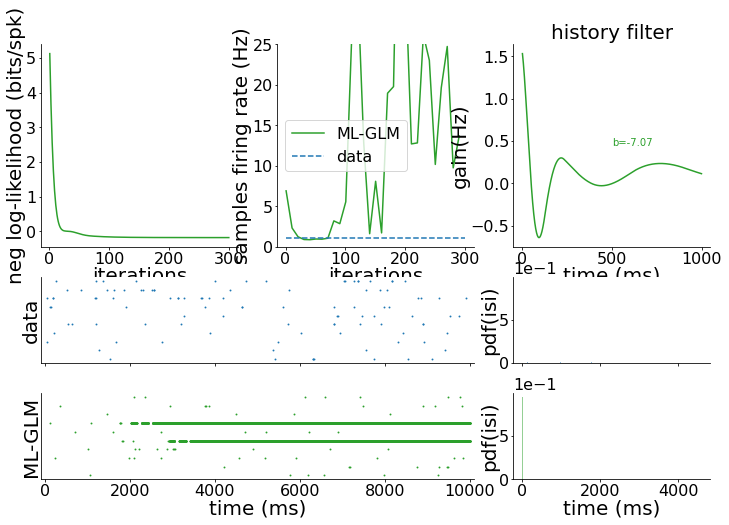

In [98]:
for key, val in metrics_ml.items():
    metrics_ml[key] = np.array(val)

ms = 0.9
arg_blow = np.where(np.sum(mask_spikes_fr_ml, 0) > 200)[0][:2]
mask = st_fr_ml.mask[:, np.random.choice(st_fr_ml.mask.shape[1], size=8, replace=False)]
mask = np.concatenate((mask, st_fr_ml.mask[:, arg_blow]), axis=1)
idx = np.random.choice(10, size=10, replace=False)
mask = mask[:, idx]
st_fr_ml_plot = SpikeTrain(st_fr_ml.t, mask)
r_fr_ml_plot = r_fr_ml[:, idx]

r1 = 2
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((4, 3), (0, 0), rowspan=r1)
ax2 = plt.subplot2grid((4, 3), (0, 1), rowspan=r1)
ax3 = plt.subplot2grid((4, 3), (0, 2), rowspan=r1)
ax4 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax5 = plt.subplot2grid((4, 3), (2, 2), colspan=1)
ax6 = plt.subplot2grid((4, 3), (3, 0), colspan=2, sharex=ax4)
ax7 = plt.subplot2grid((4, 3), (3, 2), colspan=1, sharex=ax5, sharey=ax5)

ax1.plot(iterations_ml, nll_normed_train_ml, color=palette['ml'])
# ax1.plot(iterations_ml, metrics_ml['nll_val'], color=palette['ml'])
myplt.set_labels(ax1, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

ax2.plot(iterations_ml[::n_metrics], metrics_ml['mu_fr'], '-', label='ML-GLM', color=palette['ml'])
ax2.plot([1, num_epochs + 1], [fr_train, fr_train], '--', color=palette['d'], label='data')
ax2.set_ylim(0, 25)
myplt.set_labels(ax2, xlabel='iterations', ylabel='samples firing rate (Hz)')
ax2.legend()

glm.eta.plot(t=np.arange(0, 1000, 1), ax=ax3, exp_values=False, color=palette['ml'])
myplt.set_labels(ax3, xlabel='time (ms)', ylabel='gain(Hz)', title='history filter')
ax3.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax3.transAxes)
# ax3.set_ylim(-0.4, 0.2)

st_train.plot(ax=ax4, ms=ms, color=palette['d'])
# st_val.plot(ax=ax4, ms=0.7, color=palette['d'])
ax4.tick_params(axis='both', labelbottom=False, labelleft=False)
ax4.set_yticks([])
ax4.set_ylabel('data')

ax5.hist(isi_train, density=True, color=palette['d'], label='data', alpha=0.5, bins=bins)
ax5.set_ylabel('pdf(isi)')
ax5.tick_params(axis='both', labelbottom=False)

st_fr_ml_plot.sweeps(np.arange(10)).plot(ax=ax6, ms=ms, color=palette['ml'])
myplt.set_labels(ax6, xlabel='time (ms)', ylabel='ML-GLM')
ax6.set_yticks([])

ax7.hist(isi_fr_ml, density=True, color=palette['ml'], label='ML-GLM', alpha=0.5, bins=bins)
myplt.set_labels(ax7, xlabel='time (ms)', ylabel='pdf(isi)')
ax7.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

fig.subplots_adjust(hspace=0.35)

dic = dict(basis=basis, u0_ml=glm.u0, eta_coefs_ml=glm.eta.coefs, fr_mu_ml=fr_mu_ml, fr_sd_ml=fr_sd_ml, 
           nll_normed_train_ml=nll_normed_train_ml, r_train_dc_ml=r_train_dc_ml, r_fr_ml=r_fr_ml, z_cum_ml=z_cum_ml,
           st_fr_ml=st_fr_ml, psth_ml=psth_ml, bins_ks=bins_ks, fr_ml=fr_ml, mmd_ml=mmd_ml, padding=padding, 
           isi_fr_ml=isi_fr_ml, autocor_ml=autocor_ml, lr=lr)

path = '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'ml.pk'
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)

### L2 <a name="l2"></a>  

In [106]:
path = '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'ml.pk'
with open(path, "rb") as fit_file:
    dic_ml = pickle.load(fit_file)

u0_ml, eta_coefs_ml, bins_ks = dic_ml['u0_ml'], dic_ml['eta_coefs_ml'], dic_ml['bins_ks']
del dic_ml

eta_ml = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=eta_coefs_ml)
glm_ml = TorchGLM(u0=u0_ml, eta=eta_ml)

In [107]:
lr = 5e-2
num_epochs = 200
n_metrics = 1

# alpha_l2 = 2e-1
# alpha_l2 = 5e-1
alpha_l2 = 4e-1

u00 = glm_ml.u0
eta0 = glm_ml.eta.copy()
# u00 = u0_ml
# eta0 = KernelBasisValues(basis.copy(), [0, basis.shape[0]], 1, coefs=eta_coefs_ml)

glm_l2 = TorchGLM(u0=u00, eta=eta0.copy(), noise='bernoulli')
optim = Adam(glm_l2.parameters(), lr=lr, betas=(0, 0))
loss_l2, metrics_l2 = glm_l2.train(st_train.t, st_train.mask, optim=optim, num_epochs=num_epochs, 
                                verbose=True, metrics=None, n_metrics=n_metrics, l2=True, alpha_l2=alpha_l2)
iterations_l2 = np.arange(1, num_epochs + 1, 1)
nll_normed_train_l2 = (metrics_l2['nll'] - nll_pois_proc_train) / np.log(2) / n_spk_train

_, r_train_dc_l2 = glm_l2.sample_conditioned(st_train.t, st_train.mask)
_, r_fr_l2, mask_spikes_fr_l2 = glm_l2.sample(t, shape=(2400,))
st_fr_l2 = SpikeTrain(t, mask_spikes_fr_l2)
psth_l2 = np.mean(st_fr_l2.convolve(conv_ker), 1) * 1000
isi_fr_l2 = st_fr_l2.isi_distribution()
fr_l2 = np.sum(mask_spikes_fr_l2, 0) / (t[-1] + dt) * 1000
fr_sd_l2 = np.std(fr_l2)# / np.sqrt(len(fr_l2))
fr_mu_l2 = np.mean(fr_l2)
fr_max_l2 = np.max(fr_l2)
autocor_l2 = np.mean(raw_autocorrelation(mask_spikes_fr_l2, biased=True), 1)
z_l2, ks_l2 = time_rescale_transform(dt, st_train.mask, r_train_dc_l2)
values, _ = np.histogram(np.concatenate(z_l2), bins=bins_ks)
z_cum_l2 = np.append(0., np.cumsum(values) / np.sum(values))

phi_d_l2 = phi_autocor_history(t, torch.from_numpy(r_train_dc_l2), glm_l2, padding=padding)
phi_fr_l2 = phi_autocor_history(t, torch.from_numpy(r_fr_l2), glm_l2, padding=padding)
mmd_l2 = (torch.sum((torch.mean(phi_d_l2.detach(), 1) - torch.mean(phi_fr_l2.detach(), 1))**2)).item()

 epoch 199 of 200 loss 821.9479

In [109]:
np.max(fr_l2)

2.4

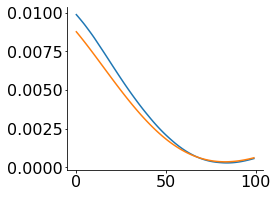

In [110]:
plt.plot(torch.mean(phi_d_l2.detach(), 1))
plt.plot(torch.mean(phi_fr_l2.detach(), 1))

NameError: name 'mean_isi_fr_l2' is not defined

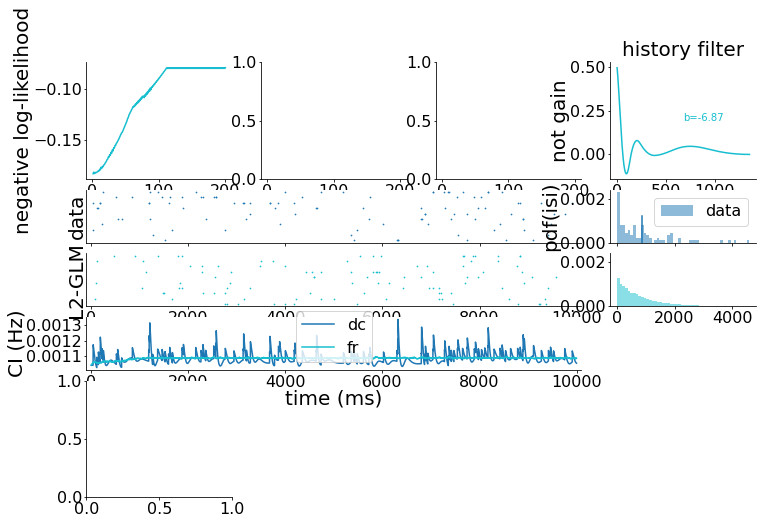

In [111]:
for key, val in metrics_l2.items():
    metrics_l2[key] = np.array(val)

ncols = 4
r1, r2 = 2, 1
nrows = 2 * r1 + 3 * r2

fig = plt.figure(figsize=(12, 8))
ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)

ax00.plot(iterations_l2, nll_normed_train_l2, color=palette['l2'])
# ax1.plot(iterations_l2, metrics_l2['nll_val'], color=palette['l2'])
myplt.set_labels(ax00, xlabel='iterations', ylabel='negative log-likelihood')

# ax2.plot(iterations_l2[::n_metrics], metrics_l2['mu_fr'], '-.', color=palette['l2'])
# ax2.plot([1, num_epochs + 1], [fr_train, fr_train], '--', color=palette['d'], label='data')
# # ax2.set_ylim(0, 25)
# myplt.set_labels(ax2, xlabel='iterations', ylabel='samples firing rate (Hz)')
# ax2.legend()

glm_l2.eta.plot(t=t_ker, ax=ax03, exp_values=False, color=palette['l2'])
myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
ax03.text(0.5, 0.5, 'b=' + str(np.round(glm_l2.u0, 2)), color=palette['l2'], transform=ax03.transAxes)
# ax03.set_ylim(-0.4, 0.2)

st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

# st_fr_l2.plot(ax=ax5, ms=0.7, color=palette['l2'])
st_fr_l2.sweeps(np.arange(10)).plot(ax=ax20, ms=0.7, color=palette['l2'])
ax20.set_yticks([])
ax20.set_ylabel('L2-GLM')

ax30.plot(t, np.mean(r_train_dc_l2, 1), color=palette['d'], label='dc')
ax30.plot(t, np.mean(r_fr_l2, 1), color=palette['l2'], label='fr')
ax30.legend()
myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

vals, bins_l2, _ = ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=50)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
ax11.set_ylabel('pdf(isi)')
ax11.tick_params(axis='both', labelbottom=False)

ax21.hist(isi_fr_l2, density=True, alpha=0.5, color=palette['l2'], label='L2-GLM', bins=bins_l2)
ax21.plot([mean_isi_fr_l2, mean_isi_fr_l2], [0, y1], '-', color=palette['l2'])
myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax40.plot(autocor_train[:argf_autocor], color=palette['d'], label='data')
ax40.plot(autocor_l2[:argf_autocor], color=palette['l2'], label='L2-GLM')
ax40.set_ylim(0, 5e-3)
myplt.set_labels(ax40, xlabel='time (ms)', ylabel='autocorrelation')
ax40.legend()

fig.subplots_adjust(hspace=0.35)

# fig.savefig('/home/diego/Dropbox/generative_glm/figures/monkey_pmv/ML.pdf', transparent=True)

In [112]:
dic_df = dict(alpha_l2=alpha_l2, u0_l2=glm_l2.u0, eta_coefs_l2=glm_l2.eta.coefs, fr_mu_l2=fr_mu_l2, fr_max_l2=fr_max_l2, fr_sd_l2=fr_sd_l2, 
           nll_normed_train_l2=nll_normed_train_l2[-1], mmd_l2=mmd_l2, padding=padding, lr=lr)

_df = pd.DataFrame.from_dict(dic_df, orient='index').T
df = pd.read_json('/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'df_l2.pk')
df = df.append(_df, ignore_index=True)
df.to_json('/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'df_l2.pk')

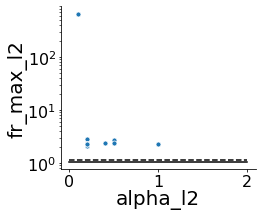

In [113]:
df = pd.read_json('/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'df_l2.pk')
ax = sns.scatterplot(x='alpha_l2', y='fr_max_l2', data=df)
ax.plot([0, 2], [fr_train, fr_train], 'k-')
ax.plot([0, 2], [1.1 * fr_train, 1.1 * fr_train], 'k--')
ax.set_yscale('log')

In [114]:
dic = dict(basis=basis, alpha_l2=alpha_l2, u0_l2=glm_l2.u0, eta_coefs_l2=glm_l2.eta.coefs, fr_mu_l2=fr_mu_l2, fr_sd_l2=fr_sd_l2, 
           nll_normed_train_l2=nll_normed_train_l2, r_train_dc_l2=r_train_dc_l2, r_fr_l2=r_fr_l2, z_cum_l2=z_cum_l2,
           st_fr_l2=st_fr_l2, psth_l2=psth_l2, bins_ks=bins_ks, mmd_l2=mmd_l2, padding=padding, 
           isi_fr_l2=isi_fr_l2, autocor_l2=autocor_l2, lr=lr)

path = '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'l2.pk'
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)

In [115]:
nll_normed_train_l2[-1]

-0.07984477169408982

### MMD <a name="mmd"></a>  

In [116]:
def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    T_train = t[-1] - t[0] + t[1]
    mu_fr = np.mean(np.sum(mask_spikes_fr.double().numpy(), 0)) / T_train * 1000
    return dict(mu_fr=mu_fr)

In [54]:
path = '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'ml.pk'
with open(path, "rb") as fit_file:
    dic_ml = pickle.load(fit_file)

u0_ml, eta_coefs_ml, bins_ks = dic_ml['u0_ml'], dic_ml['eta_coefs_ml'], dic_ml['bins_ks']
nll_normed_train_ml, z_cum_ml, isi_fr_ml = dic_ml['nll_normed_train_ml'], dic_ml['z_cum_ml'], dic_ml['isi_fr_ml']
autocor_ml = dic_ml['autocor_ml']
del dic_ml

eta_ml = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=eta_coefs_ml)
glm_ml = TorchGLM(u0=u0_ml, eta=eta_ml)

In [80]:
phi, kernel, lam_mmd, biased, lr, clip = phi_autocor_history, None, 5e3, True, 2e-2, None
kernel_kwargs = dict(padding=100)

beta0, beta1 = 0, 0
n_batch_fr = 25
biased = True
num_epochs = 600
n_metrics = 1

time0 = time.time()
u00 = glm_ml.u0
eta0 = glm_ml.eta.copy()

mmdglm = MBMMDGLM(u0=u00, eta=eta0)
optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

dtime = datetime.now()
dtime = str(dtime.year) + '/' + str(dtime.month) + '/' + str(dtime.day) + '-' + str(dtime.hour) + ':' + str(dtime.minute) + ':' + str(dtime.second)

loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, log_likelihood=True, 
                                              n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, num_epochs=num_epochs, 
                                              verbose=True, metrics=fun_metrics_mmd, kernel_kwargs=kernel_kwargs, n_metrics=n_metrics)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(2400,))
st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
fr_mmd = np.sum(mask_spikes_fr_mmd, 0) / (t[-1] + dt) * 1000
fr_sd_mmd = np.std(fr_mmd) / np.sqrt(len(fr_mmd))
fr_mean_mmd = np.mean(fr_mmd)
isi_fr_mmd = st_fr_mmd.isi_distribution()
autocor_mmd = np.mean(raw_autocorrelation(mask_spikes_fr_mmd, biased=True), 1)
z_mmd, ks_mmd = time_rescale_transform(dt, st_train.mask, r_dc_mmd)
values, bins_ks = np.histogram(np.concatenate(z_mmd), bins=bins_ks)
z_cum_mmd = np.append(0., np.cumsum(values) / np.sum(values))
mean_isi_fr_mmd = np.mean(isi_fr_mmd)

phi_d_mmd = phi_autocor_history(t, torch.from_numpy(r_dc_mmd), mmdglm, padding=kernel_kwargs['padding'])
phi_fr_mmd = phi_autocor_history(t, torch.from_numpy(r_fr_mmd), mmdglm, padding=kernel_kwargs['padding'])
mmd_mmd = (torch.sum((torch.mean(phi_d_mmd.detach(), 1) - torch.mean(phi_fr_mmd.detach(), 1))**2)).item()

time1 = time.time()
etime = (time1 - time0) / 60
print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

 epoch 599 of 600 loss 821.4979319808723
 took 341.5882749557495 seconds 5.693137915929158 minutes


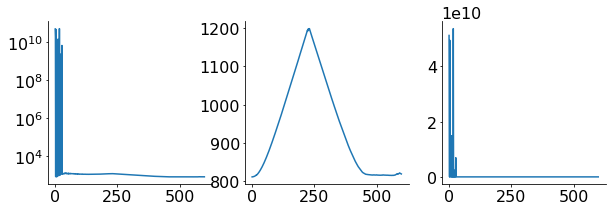

/home/diego/anaconda3/envs/generative-glm/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


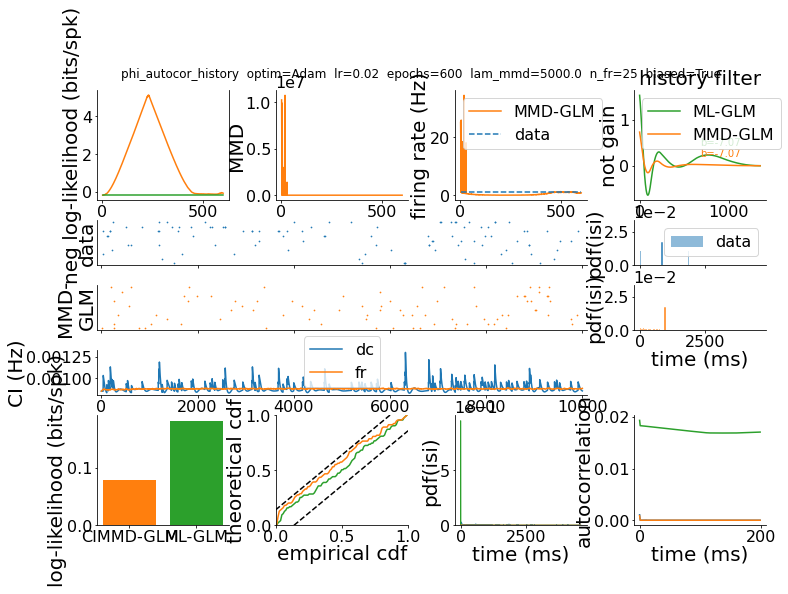

In [81]:
for key, val in metrics_mmd.items():
    metrics_mmd[key] = np.array(val)

if phi is not None:
    ker_name = phi.__name__
else:
    ker_name = kernel.__name__
    
title = ker_name + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
     + '  epochs=' + str(num_epochs) + \
       '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
ax1.plot(loss_mmd)
ax1.set_yscale('log')
ax2.plot(nll_train)
ax3.plot((loss_mmd - nll_train))
# ax3.set_ylim(0, 1e4)

ncols = 4
r1, r2 = 2, 1
nrows = 2 * r1 + 3 * r2

fig = plt.figure(figsize=(12, 8))
ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)
ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
fig.suptitle(title, fontsize=12, y=0.92)

ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
          label='ML-GLM', color=palette['ml'])
ax00.spines['right'].set_visible(True)
ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax00.legend()
myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
yf = np.median(metrics_mmd['mmd'][-10:] * 2)
# ax01.set_ylim(-1e2, yf)
myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
# ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
ax02.legend()

glm_ml.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
ax03.text(0.5, 0.5, 'b=' + str(np.round(glm_ml.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
ax03.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
ax03.legend()
# ax03.set_ylim(-0.4, 0.2)

ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
ax11.set_ylabel('pdf(isi)')
ax11.tick_params(axis='both', labelbottom=False)

# ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
# ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
ax10.set_yticks([])
ax10.set_ylabel('data')

# st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
st_fr_mmd.sweeps(np.arange(10)).plot(ax=ax20, ms=0.7, color=palette['mmd'])
ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
ax20.set_yticks([])
ax20.set_ylabel('MMD-\nGLM')

ax30.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
ax30.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
# ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')

ax30.legend()
myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

ax40.bar(0, -nll_normed_train_mmd[-1], color=palette['mmd'], label='CIMMD-GLM')
ax40.bar(1, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
# ax40.legend()
ax40.set_ylabel('log-likelihood (bits/spk)')
ax40.set_xticks([0, 1])
ax40.set_xticklabels(['CIMMD-GLM', 'ML-GLM'])

# ax40.set_ylabel('log-likelihood (bits/spk)')

ax41.plot(bins_ks, z_cum_ml, color=palette['ml'], label='ML-GLM')
ax41.plot(bins_ks, z_cum_mmd, color=palette['mmd'], label='CIMMD-GLM')
x = np.array([0, 1])
ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
# ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml[1], 2)), color=palette['ml'], transform=ax41.transAxes)
# ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

lw = 1
ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
ax42.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins)
ax42.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins)
# ax42.hist(isi_inh, density=True, alpha=1, color=palette['chen'], histtype='step', lw=lw, label='chen', bins=bins)
ax42.set_ylabel('pdf(isi)')
ax42.set_xlabel('time (ms)')
ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax42.legend()
# y1 = ax42.get_ylim()[1] / 2
# ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
# ax42.tick_params(axis='both', labelbottom=False)

argf = 200
ax43.plot(autocor_train[:argf], color=palette['d'], label='data')
ax43.plot(autocor_ml[:argf], color=palette['ml'], label='ML-GLM')
ax43.plot(autocor_mmd[:argf], color=palette['mmd'], label='MMD-GLM')
# ax43.plot(autocov_inh[:argf], color=palette['chen'], label='chen')
# ax43.set_ylim(0, 5e-3)
myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

# fig.subplots_adjust(hspace=0.35)
fig.subplots_adjust(hspace=0.45, wspace=0.35)

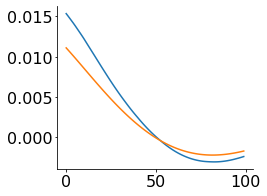

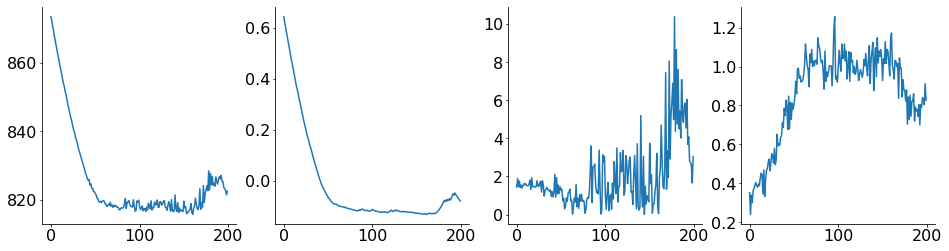

In [82]:
fig, ax = plt.subplots()
ax.plot(torch.mean(phi_d_mmd, 1))
ax.plot(torch.mean(phi_fr_mmd, 1))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(16, 4), ncols=4)
ax1.plot(loss_mmd[-200:])
ax2.plot(nll_normed_train_mmd[-200:])
ax3.plot((loss_mmd - nll_train)[-200:])
ax4.plot(metrics_mmd['mu_fr'][-200:])

# ax1.plot(loss_mmd)
# ax1.set_yscale('log')
# ax2.plot(nll_train)
# ax3.plot((loss_mmd - nll_train))

In [83]:
file_name = ker_name + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)

import os
list_files = os.listdir('/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/')

ii = 1
while file_name + '_' + str(ii) + '.pk' in list_files:
    ii += 1
file_name = file_name + '_' + str(ii) + '.pk'

import pickle
dic = dict(basis=basis, u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, ker_name=ker_name, 
           lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd, nll_train=nll_train, 
           metrics_mmd=metrics_mmd, u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs)

path = '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + file_name
with open(path, "wb") as fit_file:
    pickle.dump(dic, fit_file)

dic_df = dict(file_name=file_name, server=os.uname()[1], dtime=dtime, mmd_ker='model_based', ker_name=ker_name, 
              num_epochs=num_epochs, 
                lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, n_batch_fr=n_batch_fr, etime=etime, 
              loss_mmd=loss_mmd[-1], 
                nll_train=nll_train[-1], nll_normed_train=nll_normed_train_mmd[-1], 
              fr_mean_mmd=fr_mean_mmd, fr_max_mmd=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
              u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs, padding=kernel_kwargs['padding'])

_df = pd.DataFrame.from_dict(dic_df, orient='index').T
df = pd.read_json( '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'df_mmd.json')
df = df.append(_df, ignore_index=True)
df.to_json( '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'df_mmd.json')

## paper figure <a name="paper_figure"></a>  
[contents](#contents)

#### load ml

In [117]:
path = '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'ml.pk'
with open(path, "rb") as fit_file:
    dic_ml = pickle.load(fit_file)

basis = dic_ml['basis']
u0_ml, eta_coefs_ml = dic_ml['u0_ml'], dic_ml['eta_coefs_ml']
nll_normed_train_ml = dic_ml['nll_normed_train_ml']
r_train_dc_ml, r_fr_ml = dic_ml['r_train_dc_ml'], dic_ml['r_fr_ml']
z_cum_ml = dic_ml['z_cum_ml']
st_fr_ml, isi_fr_ml = dic_ml['st_fr_ml'], dic_ml['isi_fr_ml']
autocor_ml = dic_ml['autocor_ml']
bins_ks = dic_ml['bins_ks']
fr_ml = dic_ml['fr_ml']
mmd_ml = dic_ml['mmd_ml']
psth_ml = dic_ml['psth_ml']

eta_ml = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=eta_coefs_ml)
glm_ml = TorchGLM(u0=u0_ml, eta=eta_ml)

# phi_d_ml = phi_autocov(t, torch.from_numpy(r_train_dc_ml), glm)
# phi_fr_ml = phi_autocov(t, torch.from_numpy(r_fr_ml[:len(t)]), glm)
# mmd_ml = (torch.sum((torch.mean(phi_d_ml.detach(), 1) - torch.mean(phi_fr_ml.detach(), 1))**2)).item()

In [118]:
fr_ml = np.sum(st_fr_ml.mask, 0) / (st_fr_ml.mask.shape[0] * dt) * 1000
sweeps_ml = np.argsort(fr_ml)[np.array([0, 1, 600, 601, 1200, 1201, 1800, 1801, 2358, 2399])]
np.random.shuffle(sweeps_ml)

In [119]:
# print(np.sum(fr_ml > 10), np.sum(fr_ml > 10) / len(fr_ml))
# mask_spikes_fr_ml_stable = st_fr_ml.mask[:, fr_ml < 10]
# st_fr_ml_stable = SpikeTrain(st_fr_ml.t, mask_spikes_fr_ml_stable)
# isi_fr_ml_stable = st_fr_ml_stable.isi_distribution()
# autocov_ml_stable = np.mean(raw(mask_spikes_fr_ml_stable, method='fft', subtract_mean=False, stationary_signal=False, biased=False), 1)

#### load l2

In [120]:
path = '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'l2.pk'
with open(path, "rb") as fit_file:
    dic_l2 = pickle.load(fit_file)

u0_l2, eta_coefs_l2 = dic_l2['u0_l2'], dic_l2['eta_coefs_l2']
nll_normed_train_l2 = dic_l2['nll_normed_train_l2']
r_train_dc_l2, r_fr_l2 = dic_l2['r_train_dc_l2'], dic_l2['r_fr_l2']
z_cum_l2 = dic_l2['z_cum_l2']
st_fr_l2, isi_fr_l2 = dic_l2['st_fr_l2'], dic_l2['isi_fr_l2']
autocor_l2 = dic_l2['autocor_l2']
# bins_ks = dic_l2['bins_ks']
mmd_l2 = dic_l2['mmd_l2']
psth_l2 = dic_l2['psth_l2']

eta_l2 = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=eta_coefs_l2)
glm_l2 = TorchGLM(u0=u0_l2, eta=eta_l2)

#### load mmd

In [57]:
path = '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/'
df = pd.read_json('/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'df_mmd.json')

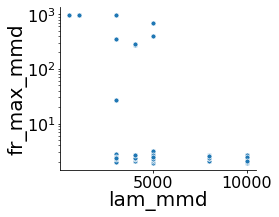

In [58]:
data = df[(df.num_epochs == 600)]

fig, ax = plt.subplots()
sns.scatterplot(x='lam_mmd', y='fr_max_mmd', data=data, ax=ax)
ax.set_yscale('log')

## load mmd

In [59]:
path = '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/'
# pk_files = [f for f in os.listdir(path) if f[-3:] == '.pk' and 'lammmd5000.0' in f]
pk_files = list(df[(df.num_epochs == 600) & (df.lam_mmd == 8e3) & (df.padding == 100)].file_name)

print(len(pk_files))

u0, eta_vals, eta_coefs, nll_train, mmd_mmd, autocor_mmd = [], [], [], [], [], []
for pkf in pk_files:
    with open(path + pkf, "rb") as file:
        dic = pickle.load(file)
    _eta_vals = np.dot(dic['basis'], dic['eta_coefs_mmd'])
    
    eta_mmd = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=dic['eta_coefs_mmd'])
    mmdglm = TorchGLM(u0=dic['u0_mmd'], eta=eta_mmd)
    _, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
#     _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(st_train.mask.shape[1],))
    _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(2400,))
#     phi_d_mmd = phi_autocov(t, torch.from_numpy(r_dc_mmd), mmdglm)
#     phi_fr_mmd = phi_autocov(t, torch.from_numpy(r_fr_mmd), mmdglm)
#     _mmd_mmd = (torch.sum((torch.mean(phi_d_mmd.detach(), 1) - torch.mean(phi_fr_mmd.detach(), 1))**2)).item()
    _mmd_mmd = df.set_index('file_name').loc[pkf, 'mmd_mmd']
    _autocor_mmd = np.mean(raw_autocorrelation(mask_spikes_fr_mmd, biased=True), 1)
    
    
    eta_vals.append(_eta_vals)
    u0.append(dic['u0_mmd'])
    eta_coefs.append(dic['eta_coefs_mmd'])
    nll_train.append(dic['nll_train'][-1])
    mmd_mmd.append(_mmd_mmd)
    autocor_mmd.append(_autocor_mmd[:argf_autocor] / _autocor_mmd[0])
    
eta_vals = np.stack(eta_vals, 1)
eta_coefs = np.stack(eta_coefs, 1)
autocor_mmd = np.stack(autocor_mmd, 1)
eta_vals_mean = np.mean(eta_vals, 1)
u0_mean = np.mean(u0)
eta_coefs_mean = np.mean(eta_coefs, 1)

ll_normed_train_mmd = -(nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train

p0, pf = 5, 95

eta_vals0 = np.percentile(eta_vals, p0, axis=1)
eta_valsm = np.percentile(eta_vals, 50, axis=1)
eta_valsf = np.percentile(eta_vals, pf, axis=1)

autocor_mmd0 = np.percentile(autocor_mmd, p0, axis=1)
autocor_mmdm = np.percentile(autocor_mmd, 50, axis=1)
autocor_mmdf = np.percentile(autocor_mmd, pf, axis=1)

u0_m = np.percentile(u0, 50)
u0_0 = u0_m - np.percentile(u0, p0)
u0_f = np.percentile(u0, pf) - u0_m

ll_normed_train_mmd_m = np.percentile(ll_normed_train_mmd, 50)
ll_normed_train_mmd_0 = ll_normed_train_mmd_m - np.percentile(ll_normed_train_mmd, p0)
ll_normed_train_mmd_f = np.percentile(ll_normed_train_mmd, pf) - ll_normed_train_mmd_m

mmd_mmd_m = np.percentile(mmd_mmd, 50)
mmd_mmd_0 = mmd_mmd_m - np.percentile(mmd_mmd, p0)
mmd_mmd_f = np.percentile(mmd_mmd, pf) - mmd_mmd_m

16


In [60]:
eta_mmd = KernelBasisValues(basis, [0, basis.shape[0]], 1, coefs=eta_coefs_mean)
mmdglm = TorchGLM(u0=u0_mean, eta=eta_mmd)

_, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(t, shape=(2400,))
st_fr_mmd = SpikeTrain(t, mask_spikes_fr_mmd)
isi_fr_mmd = st_fr_mmd.isi_distribution()
fr_mmd = np.sum(mask_spikes_fr_mmd, 0) / (t[-1] + dt) * 1000
# # fr_sd_mmd = np.std(fr_mmd) / np.sqrt(len(fr_mmd))
# # fr_mmd = np.mean(fr_mmd)

z_mmd, ks_mmd = time_rescale_transform(dt, st_train.mask, r_dc_mmd)
values, bins_ks = np.histogram(np.concatenate(z_mmd), bins=bins_ks)
z_cum_mmd = np.append(0., np.cumsum(values) / np.sum(values))

psth_mmd = np.mean(st_fr_mmd.convolve(conv_ker), 1) * 1000

bins_isi = np.arange(0, np.max([np.max(isi_train), np.max(isi_fr_mmd), np.max(isi_fr_l2), np.max(isi_fr_ml)]) + 1, 1)

In [61]:
# for ii in range(10):
#     _, _, mask = mmdglm.sample(t, shape=(2400, ))
#     print(np.max(np.sum(mask, 0) / 10))

In [62]:
# psth_d = np.mean(st_train.convolve(conv_ker), 1) * 1000

# mmd_ml = (torch.sum((torch.mean(phi_d_ml.detach(), 1) - torch.mean(phi_fr_ml.detach(), 1))**2)).item()

In [ ]:
fig, (axd, axeta, axmmd, axml, axac, axpsth, axisi, axmmds, axll, axpp) = plot_layout_fig3((11, 14))
fig.subplots_adjust(hspace=0.65, wspace=0.6)
axd.set_title('Human Cortex', fontsize=16)

axll.bar(0, ll_normed_train_mmd_m, color=palette['mmd'], label='MMD-GLM', yerr=np.array([ll_normed_train_mmd_0, ll_normed_train_mmd_f]).reshape(2, 1))
axll.bar(1, -nll_normed_train_l2[-1], color=palette['l2'], label='L2-GLM')
axll.bar(2, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
axll.set_yticks([0, 1e-1, 2e-1])

axmmds.bar(0, mmd_mmd_m, color=palette['mmd'], label='MMD-GLM', yerr=np.array([mmd_mmd_0, mmd_mmd_f]).reshape(2, 1))
axmmds.bar(1, mmd_l2, color=palette['l2'], label='L2-GLM')
axmmds.bar(2, mmd_ml, color=palette['ml'], label='ML-GLM')
axmmds.set_yscale('log')
axmmds.set_yticks([1e0, 1e7])

axpp.plot(bins_ks, z_cum_ml, color=palette['ml'], label='ML-GLM')
axpp.plot(bins_ks, z_cum_mmd, color=palette['mmd'], label='CIMMD-GLM')
x = np.array([0, 1])
axpp.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
axpp.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')

glm_ml.eta.plot(t=t_ker, ax=axeta, exp_values=True, label='ML-GLM', color=palette['ml'])
glm_l2.eta.plot(t=t_ker, ax=axeta, exp_values=True, label='L2-GLM', color=palette['l2'])
axeta.plot(t_ker, np.exp(eta_valsm), label='MMD-GLM', color=palette['mmd'])
axeta.fill_between(t_ker, np.exp(eta_vals0), np.exp(eta_valsf), alpha=0.5, color=palette['mmd'])
myplt.set_labels(axeta, xlabel='time (ms)', ylabel='gain', title='history filter')

axbias = inset_axes(axeta, width=1.1, height=0.5, bbox_to_anchor=(0, 0.5, .9, .3),
                   bbox_transform=axeta.transAxes)
plot_errorbar([u0_m, glm_l2.u0, glm_ml.u0], yerr=[np.array([u0_0, u0_f]).reshape(2, 1), None, None], color=[palette['mmd'], palette['l2'], palette['ml']], ax=axbias, 
              ms=20, mew=2.5, capsize=5, capthick=1)
axbias_fontsize = 12
axbias.set_ylabel('bias', fontsize=axbias_fontsize)
axbias.set_xticks(range(3))
xlabels = ['MMD', 'L2', 'ML']
axbias.set_xticklabels(xlabels, fontsize=axbias_fontsize, rotation=45)
axbias.tick_params(labelsize=axbias_fontsize)
space = 0.5
axbias.set_xlim(0 - space, 2 + space)
# axbias.set_yticks([-3.9, -3.7])
axbias.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=-7, useMathText=True)
axbias.yaxis.get_offset_text().set_fontsize(axbias_fontsize - 1)

st_train.plot(ax=axd, ms=ms_raster, color=palette['d'])
# axd.tick_params(axis='both', labelbottom=False, labelleft=False)
# axd.set_yticks([])
# axd.set_ylabel('data')
# sns.despine(ax=axd, top=False, right=False)

st_fr_ml.sweeps(sweeps_ml).plot(ax=axml, ms=ms_raster, color=palette['ml'])
# axml.tick_params(axis='both', labelbottom=False, labelleft=False)
# axml.set_yticks([])
# axml.set_ylabel('ML-GLM')
# sns.despine(ax=axml, top=False, right=False)

lw = 1
axisi.plot([0], [0], color=palette['d'], label='data')
axisi.plot([0], [0], color=palette['mmd'], label='MMD-GLM')
axisi.plot([0], [0], color=palette['l2'], label='L2-GLM')
axisi.plot([0], [0], color=palette['ml'], label='ML-GLM')
axisi.legend(loc='lower right', frameon=False)
axisi.hist(isi_train, density=True, cumulative=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
axisi.hist(isi_fr_ml, density=True, cumulative=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins)
axisi.hist(isi_fr_l2, density=True, cumulative=True, alpha=1, color=palette['l2'], histtype='step', lw=lw, label='L2-GLM', bins=bins)
axisi.hist(isi_fr_mmd, density=True, cumulative=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='MMD-GLM', bins=bins)
axisi.set_ylabel('cumulative')
axisi.set_xlabel('isi (ms)')
axisi.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axisi.set_xlim(-100, 4200)

st_fr_mmd.sweeps(np.arange(10)).plot(ax=axmmd, ms=ms_raster, color=palette['mmd'])
# axmmd.tick_params(axis='both', labelbottom=False, labelleft=False)
# axmmd.set_yticks([])
# sns.despine(ax=axmmd, top=False, right=False)

argf = 200

autocor_train = autocor_train[:argf] / autocor_train[0]

delta = 2
# ker_ma = KernelRect([-delta, delta + dt], coefs=[1 / (2 * delta)])
# autocor_train_smooth = ker_ma.convolve_continuous(t, autocor_train)
autocor_train_smooth = np.array([np.mean(autocor_train[ii - delta:ii + delta]) for ii in range(delta, len(autocor_train), 1)])

axac.plot(autocor_train_smooth, color=palette['d'], label='data')
axac.plot(autocor_ml[:argf] / autocor_ml[0], color=palette['ml'], label='ML-GLM')
axac.plot(autocor_l2[:argf] / autocor_l2[0], color=palette['l2'], label='L2')
axac.plot(autocor_mmdm[:argf], label='MMD-GLM', color=palette['mmd'])
axac.fill_between(np.arange(0, argf, 1), autocor_mmd0[:argf_autocor], autocor_mmdf[:argf_autocor], alpha=0.5, color=palette['mmd'])
axac.set_ylim(0, 2e-2)
axac.set_yticks([1e-2, 2e-2])
myplt.set_labels(axac, xlabel='time (ms)', ylabel='autocorrelation')
axac.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

alpha = 1
axpsth.plot(t, psth_d, alpha=alpha, color=palette['d'])
axpsth.plot(t, psth_ml, alpha=alpha, color=palette['ml'])
axpsth.plot(t, psth_l2, alpha=alpha, color=palette['l2'])
axpsth.plot(t, psth_mmd, alpha=alpha, color=palette['mmd'])
axpsth.set_ylim(axpsth.get_ylim()[0], 10)

fig.savefig('./fig3b.pdf', transparent=True, bbox_inches='tight')
fig.savefig('./fig3b.svg', transparent=True, bbox_inches='tight')

In [103]:
# dic = dict(iterations_mmd=iterations_mmd, mmd=metrics_mmd['mmd'], nll_normed_mmd=nll_normed_mmd, nll_normed_ml=nll_normed_ml, 
#            t_ker=t_ker, u0_ml=glm.u0, u0_coefs_ml=glm.eta.coefs, u0_mmd=mmdglm.u0, u0_coefs_mmd=mmdglm.eta.coefs, 
#            eta_coefs_ml=glm.eta.coefs, mask_spikes=st.mask, mask_spikes_mmd=st_fr_mmd.mask)

# import pickle
# path = './fig2'
# with open(path, "wb") as fit_file:
#     pickle.dump(dic, fit_file)

NameError: name 'nll_normed_mmd' is not defined

 epoch 599 of 600 loss 817.7917164201495
 took 348.63326144218445 seconds 5.810554357369741 minutes
 epoch 599 of 600 loss 821.5507992833426
 took 380.2318420410156 seconds 6.33719736735026 minutes
 epoch 599 of 600 loss 819.5003801057627
 took 386.4003164768219 seconds 6.440005274613698 minutes
 epoch 599 of 600 loss 821.833445077633
 took 368.6257531642914 seconds 6.14376255273819 minutes
 epoch 599 of 600 loss 819.700915887117
 took 367.72549057006836 seconds 6.128758176167806 minutes
 epoch 599 of 600 loss 819.051714913958
 took 368.47665071487427 seconds 6.141277511914571 minutes


<ipython-input-87-620ee28e5461>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
<ipython-input-87-620ee28e5461>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8))
<ipython-input-87-620ee28e5461>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_

 epoch 599 of 600 loss 817.9173204132969
 took 364.1712839603424 seconds 6.06952139933904 minutes


<ipython-input-87-620ee28e5461>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
<ipython-input-87-620ee28e5461>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8))
<ipython-input-87-620ee28e5461>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_

 epoch 599 of 600 loss 823.5451492115696
 took 360.97067165374756 seconds 6.016177860895793 minutes


<ipython-input-87-620ee28e5461>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
<ipython-input-87-620ee28e5461>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8))
<ipython-input-87-620ee28e5461>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_

 epoch 599 of 600 loss 818.3110423145696
 took 370.5160102844238 seconds 6.17526683807373 minutes


<ipython-input-87-620ee28e5461>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
<ipython-input-87-620ee28e5461>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8))
<ipython-input-87-620ee28e5461>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_

 epoch 599 of 600 loss 819.4680145899505
 took 373.74307680130005 seconds 6.229051280021667 minutes


<ipython-input-87-620ee28e5461>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
<ipython-input-87-620ee28e5461>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8))
<ipython-input-87-620ee28e5461>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_

 epoch 599 of 600 loss 820.0046193441264
 took 370.9189193248749 seconds 6.181981988747915 minutes


<ipython-input-87-620ee28e5461>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
<ipython-input-87-620ee28e5461>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8))
<ipython-input-87-620ee28e5461>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_

 epoch 599 of 600 loss 818.1332749466586
 took 375.3915684223175 seconds 6.2565261403719585 minutes


<ipython-input-87-620ee28e5461>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
<ipython-input-87-620ee28e5461>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8))
<ipython-input-87-620ee28e5461>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_

 epoch 599 of 600 loss 818.3182606159476
 took 368.00002813339233 seconds 6.133333802223206 minutes


<ipython-input-87-620ee28e5461>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
<ipython-input-87-620ee28e5461>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8))
<ipython-input-87-620ee28e5461>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_

 epoch 599 of 600 loss 820.0233375832969
 took 413.9600169658661 seconds 6.899333616097768 minutes


<ipython-input-87-620ee28e5461>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
<ipython-input-87-620ee28e5461>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8))
<ipython-input-87-620ee28e5461>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_

 epoch 599 of 600 loss 818.620618517619
 took 402.4628179073334 seconds 6.70771363178889 minutes


<ipython-input-87-620ee28e5461>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
<ipython-input-87-620ee28e5461>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8))
<ipython-input-87-620ee28e5461>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_

 epoch 599 of 600 loss 819.256992996296
 took 400.1184289455414 seconds 6.6686404824256895 minutes


<ipython-input-87-620ee28e5461>:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
<ipython-input-87-620ee28e5461>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 8))
<ipython-input-87-620ee28e5461>:193: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_

 epoch 247 of 600 loss 1250.041405662494

KeyboardInterrupt: 

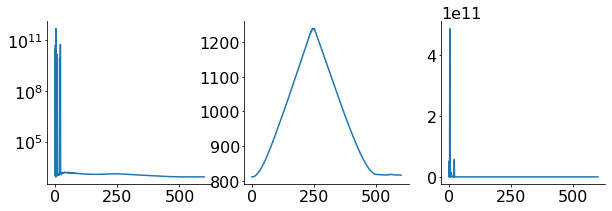

In [ ]:
for ii in range(20):

    phi, kernel, lam_mmd, biased, lr, clip = phi_autocor_history, None, 8e3, True, 2e-2, None
    kernel_kwargs = dict(padding=100)

    beta0, beta1 = 0, 0
    n_batch_fr = 25
    biased = True
    num_epochs = 600
    n_metrics = 1

    time0 = time.time()
    u00 = glm_ml.u0
    eta0 = glm_ml.eta.copy()

    mmdglm = MBMMDGLM(u0=u00, eta=eta0)
    optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

    dtime = datetime.now()
    dtime = str(dtime.year) + '/' + str(dtime.month) + '/' + str(dtime.day) + '-' + str(dtime.hour) + ':' + str(dtime.minute) + ':' + str(dtime.second)

    loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, log_likelihood=True, 
                                                  n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, num_epochs=num_epochs, 
                                                  verbose=True, metrics=fun_metrics_mmd, kernel_kwargs=kernel_kwargs, n_metrics=n_metrics)
    loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
    nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
    metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
    iterations_mmd = np.arange(1, num_epochs + 1, 1)

    _, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
    _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(2400,))
    st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
    fr_mmd = np.sum(mask_spikes_fr_mmd, 0) / (t[-1] + dt) * 1000
    fr_sd_mmd = np.std(fr_mmd) / np.sqrt(len(fr_mmd))
    fr_mean_mmd = np.mean(fr_mmd)
    isi_fr_mmd = st_fr_mmd.isi_distribution()
    autocor_mmd = np.mean(raw_autocorrelation(mask_spikes_fr_mmd, biased=True), 1)
    z_mmd, ks_mmd = time_rescale_transform(dt, st_train.mask, r_dc_mmd)
    values, bins_ks = np.histogram(np.concatenate(z_mmd), bins=bins_ks)
    z_cum_mmd = np.append(0., np.cumsum(values) / np.sum(values))
    mean_isi_fr_mmd = np.mean(isi_fr_mmd)

    phi_d_mmd = phi_autocor_history(t, torch.from_numpy(r_dc_mmd), mmdglm, padding=kernel_kwargs['padding'])
    phi_fr_mmd = phi_autocor_history(t, torch.from_numpy(r_fr_mmd), mmdglm, padding=kernel_kwargs['padding'])
    mmd_mmd = (torch.sum((torch.mean(phi_d_mmd.detach(), 1) - torch.mean(phi_fr_mmd.detach(), 1))**2)).item()

    time1 = time.time()
    etime = (time1 - time0) / 60
    print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

    for key, val in metrics_mmd.items():
        metrics_mmd[key] = np.array(val)

    if phi is not None:
        ker_name = phi.__name__
    else:
        ker_name = kernel.__name__

    title = ker_name + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
         + '  epochs=' + str(num_epochs) + \
           '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased)

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
    ax1.plot(loss_mmd)
    ax1.set_yscale('log')
    ax2.plot(nll_train)
    ax3.plot((loss_mmd - nll_train))
    # ax3.set_ylim(0, 1e4)

    ncols = 4
    r1, r2 = 2, 1
    nrows = 2 * r1 + 3 * r2

    fig = plt.figure(figsize=(12, 8))
    ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
    ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
    ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
    ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
    ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
    ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
    ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
    ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
    ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
    ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)
    ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
    ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
    ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
    fig.suptitle(title, fontsize=12, y=0.92)

    ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
    ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
              label='ML-GLM', color=palette['ml'])
    ax00.spines['right'].set_visible(True)
    ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax00.legend()
    myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

    ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
    ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    yf = np.median(metrics_mmd['mmd'][-10:] * 2)
    # ax01.set_ylim(-1e2, yf)
    myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

    ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
    ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
    # ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
    myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
    ax02.legend()

    glm_ml.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
    mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
    myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
    ax03.text(0.5, 0.5, 'b=' + str(np.round(glm_ml.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
    ax03.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
    ax03.legend()
    # ax03.set_ylim(-0.4, 0.2)

    ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
    ax11.legend()
    y1 = ax11.get_ylim()[1] / 2
    ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    ax11.set_ylabel('pdf(isi)')
    ax11.tick_params(axis='both', labelbottom=False)

    # ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
    # ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
    ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
    ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
    myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
    ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
    ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax10.set_yticks([])
    ax10.set_ylabel('data')

    # st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
    st_fr_mmd.sweeps(np.arange(10)).plot(ax=ax20, ms=0.7, color=palette['mmd'])
    ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
    ax20.set_yticks([])
    ax20.set_ylabel('MMD-\nGLM')

    ax30.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
    ax30.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
    # ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')

    ax30.legend()
    myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

    ax40.bar(0, -nll_normed_train_mmd[-1], color=palette['mmd'], label='CIMMD-GLM')
    ax40.bar(1, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
    # ax40.legend()
    ax40.set_ylabel('log-likelihood (bits/spk)')
    ax40.set_xticks([0, 1])
    ax40.set_xticklabels(['CIMMD-GLM', 'ML-GLM'])

    # ax40.set_ylabel('log-likelihood (bits/spk)')

    ax41.plot(bins_ks, z_cum_ml, color=palette['ml'], label='ML-GLM')
    ax41.plot(bins_ks, z_cum_mmd, color=palette['mmd'], label='CIMMD-GLM')
    x = np.array([0, 1])
    ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
    ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
    myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
    ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
    # ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml[1], 2)), color=palette['ml'], transform=ax41.transAxes)
    # ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

    lw = 1
    ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
    ax42.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins)
    ax42.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins)
    # ax42.hist(isi_inh, density=True, alpha=1, color=palette['chen'], histtype='step', lw=lw, label='chen', bins=bins)
    ax42.set_ylabel('pdf(isi)')
    ax42.set_xlabel('time (ms)')
    ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # ax42.legend()
    # y1 = ax42.get_ylim()[1] / 2
    # ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
    # ax42.tick_params(axis='both', labelbottom=False)

    argf = 200
    ax43.plot(autocor_train[:argf], color=palette['d'], label='data')
    ax43.plot(autocor_ml[:argf], color=palette['ml'], label='ML-GLM')
    ax43.plot(autocor_mmd[:argf], color=palette['mmd'], label='MMD-GLM')
    # ax43.plot(autocor_inh[:argf], color=palette['chen'], label='chen')
    # ax43.set_ylim(0, 5e-3)
    myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

    # fig.subplots_adjust(hspace=0.35)
    fig.subplots_adjust(hspace=0.45, wspace=0.35)

    fig, ax = plt.subplots()
    ax.plot(torch.mean(phi_d_mmd, 1))
    ax.plot(torch.mean(phi_fr_mmd, 1))

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(16, 4), ncols=4)
    ax1.plot(loss_mmd[-200:])
    ax2.plot(nll_normed_train_mmd[-200:])
    ax3.plot((loss_mmd - nll_train)[-200:])
    ax4.plot(metrics_mmd['mu_fr'][-200:])

    # ax1.plot(loss_mmd)
    # ax1.set_yscale('log')
    # ax2.plot(nll_train)
    # ax3.plot((loss_mmd - nll_train))

    file_name = ker_name + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)

    import os
    list_files = os.listdir('/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/')

    ii = 1
    while file_name + '_' + str(ii) + '.pk' in list_files:
        ii += 1
    file_name = file_name + '_' + str(ii) + '.pk'

    import pickle
    dic = dict(basis=basis, u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, ker_name=ker_name, 
               lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd, nll_train=nll_train, 
               metrics_mmd=metrics_mmd, u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs)

    path = '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + file_name
    with open(path, "wb") as fit_file:
        pickle.dump(dic, fit_file)

    dic_df = dict(file_name=file_name, server=os.uname()[1], dtime=dtime, mmd_ker='model_based', ker_name=ker_name, 
                  num_epochs=num_epochs, 
                    lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, n_batch_fr=n_batch_fr, etime=etime, 
                  loss_mmd=loss_mmd[-1], 
                    nll_train=nll_train[-1], nll_normed_train=nll_normed_train_mmd[-1], 
                  fr_mean_mmd=fr_mean_mmd, fr_max_mmd=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
                  u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs, padding=kernel_kwargs['padding'])

    _df = pd.DataFrame.from_dict(dic_df, orient='index').T
    df = pd.read_json( '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'df_mmd.json')
    df = df.append(_df, ignore_index=True)
    df.to_json( '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'df_mmd.json')

In [ ]:
plt.close('all')

In [221]:
import itertools

pars = itertools.product([3.5, 4.5e3], [600, 800])

In [ ]:
for lam_mmd, num_epochs in pars:
    for ii in range(5):
#         phi, kernel, lam_mmd, biased, lr, clip = phi_autocov, None, 2.5e3, True, 2e-2, 1e0
        phi, kernel, biased, lr, clip = phi_autocov, None, True, 2e-2, 1e0
        kernel_kwargs = dict(padding=200)

        beta0, beta1 = 0, 0
        n_batch_fr = 40
        biased = True
#         num_epochs = 600
        n_metrics = 1

        time0 = time.time()
        u00 = glm_ml.u0
        eta0 = glm_ml.eta.copy()
        # eta0_scaled = glm.eta.copy()
        # eta0_scaled.coefs = eta0_scaled.coefs * 0.1

        mmdglm = CIMMDGLM(u0=u00, eta=eta0)
        optim = Adam(mmdglm.parameters(), lr=lr, betas=(beta0, beta1))

        dtime = datetime.now()
        dtime = str(dtime.year) + '/' + str(dtime.month) + '/' + str(dtime.day) + '-' + str(dtime.hour) + ':' + str(dtime.minute) + ':' + str(dtime.second)

        loss_mmd, nll_train, metrics_mmd = mmdglm.train(t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, log_likelihood=True, 
                                                      n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, biased=biased, optim=optim, clip=clip, num_epochs=num_epochs, 
                                                      verbose=True, metrics=fun_metrics_mmd, kernel_kwargs=kernel_kwargs, n_metrics=n_metrics)
        loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
        nll_normed_train_mmd = (nll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
        metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
        iterations_mmd = np.arange(1, num_epochs + 1, 1)

        _, r_dc_mmd = mmdglm.sample_conditioned(st_train.t, st_train.mask)
        _, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_train.t, shape=(2400,))
        st_fr_mmd = SpikeTrain(st_train.t, mask_spikes_fr_mmd)
        fr_mmd = np.sum(mask_spikes_fr_mmd, 0) / (t[-1] + dt) * 1000
        fr_sd_mmd = np.std(fr_mmd) / np.sqrt(len(fr_mmd))
        fr_mean_mmd = np.mean(fr_mmd)
        isi_fr_mmd = st_fr_mmd.isi_distribution()
        autocov_mmd = np.mean(auto_covariance(mask_spikes_fr_mmd, method='fft', 
                                                   subtract_mean=False, stationary_signal=False, biased=False), 1)
        z_mmd, ks_mmd = time_rescale_transform(dt, st_train.mask, r_dc_mmd)
        values, bins_ks = np.histogram(np.concatenate(z_mmd), bins=bins_ks)
        z_cum_mmd = np.append(0., np.cumsum(values) / np.sum(values))
        mean_isi_fr_mmd = np.mean(isi_fr_mmd)

        phi_d_mmd = phi_autocov(t, torch.from_numpy(r_dc_mmd), mmdglm, padding=kernel_kwargs['padding'])
        phi_fr_mmd = phi_autocov(t, torch.from_numpy(r_fr_mmd[:len(t)]), mmdglm, padding=kernel_kwargs['padding'])
        mmd_mmd = (torch.sum((torch.mean(phi_d_mmd.detach(), 1) - torch.mean(phi_fr_mmd.detach(), 1))**2)).item()

        time1 = time.time()
        etime = (time1 - time0) / 60
        print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

        for key, val in metrics_mmd.items():
            metrics_mmd[key] = np.array(val)

        if phi is not None:
            ker_name = phi.__name__
        else:
            ker_name = kernel.__name__

        title = "k(r, r')=" + dic_ker_strings[ker_name] + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
             + '  epochs=' + str(num_epochs) + \
               '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased)

        fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
        ax1.plot(loss_mmd)
        ax2.plot(nll_train)
        ax3.plot((loss_mmd - nll_train))
        # ax3.set_ylim(0, 1e4)

        ncols = 4
        r1, r2 = 2, 1
        nrows = 2 * r1 + 3 * r2

        fig = plt.figure(figsize=(12, 8))
        ax00 = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=r1)
        ax01 = plt.subplot2grid((nrows, ncols), (0, 1), rowspan=r1, sharex=ax00)
        ax02 = plt.subplot2grid((nrows, ncols), (0, 2), rowspan=r1, sharex=ax00)
        ax03 = plt.subplot2grid((nrows, ncols), (0, 3), rowspan=r1)
        ax10 = plt.subplot2grid((nrows, ncols), (r1, 0), colspan=ncols - 1)
        ax11 = plt.subplot2grid((nrows, ncols), (r1, ncols - 1), colspan=1)
        ax20 = plt.subplot2grid((nrows, ncols), (r1 + r2, 0), colspan=ncols - 1, sharex=ax10)
        ax21 = plt.subplot2grid((nrows, ncols), (r1 + r2, ncols - 1), colspan=1, sharex=ax11, sharey=ax11)
        ax30 = plt.subplot2grid((nrows, ncols), (r1 + 2*r2, 0), colspan=ncols - 1, sharex=ax10)
        ax40 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 0), rowspan=r1)
        ax41 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 1), rowspan=r1)
        ax42 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 2), rowspan=r1)
        ax43 = plt.subplot2grid((nrows, ncols), (r1 + 3*r2, 3), rowspan=r1)
        fig.suptitle(title, fontsize=12, y=0.92)

        ax00.plot(iterations_mmd, nll_normed_train_mmd, '-', label='train', color=palette['mmd'])
        ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_normed_train_mmd[0], nll_normed_train_mmd[0]], '-', 
                  label='ML-GLM', color=palette['ml'])
        ax00.spines['right'].set_visible(True)
        ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        # ax00.legend()
        myplt.set_labels(ax00, xlabel='iterations', ylabel='neg log-likelihood (bits/spk)')

        ax01.plot(iterations_mmd[::n_metrics], metrics_mmd['mmd'], label='MMD-GLM', color=palette['mmd'])
        ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        yf = np.median(metrics_mmd['mmd'][-10:] * 2)
        # ax01.set_ylim(-1e2, yf)
        myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

        ax02.plot(iterations_mmd[::n_metrics], metrics_mmd['mu_fr'], label='MMD-GLM', color=palette['mmd'])
        ax02.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_train, fr_train], '--', label='data', color=palette['d'])
        # ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
        myplt.set_labels(ax02, xlabel='iterations', ylabel='firing rate (Hz)')
        ax02.legend()

        glm_ml.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='ML-GLM', color=palette['ml'])
        mmdglm.eta.plot(t=t_ker, ax=ax03, exp_values=False, label='MMD-GLM', color=palette['mmd'])
        myplt.set_labels(ax03, xlabel='time (ms)', ylabel='not gain', title='history filter')
        ax03.text(0.5, 0.5, 'b=' + str(np.round(glm_ml.u0, 2)), color=palette['ml'], transform=ax03.transAxes)
        ax03.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax03.transAxes)
        ax03.legend()
        # ax03.set_ylim(-0.4, 0.2)

        ax11.hist(isi_train, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
        ax11.legend()
        y1 = ax11.get_ylim()[1] / 2
        ax11.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
        ax11.set_ylabel('pdf(isi)')
        ax11.tick_params(axis='both', labelbottom=False)

        # ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
        # ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
        ax21.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
        ax21.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
        myplt.set_labels(ax21, xlabel='time (ms)', ylabel='pdf(isi)')
        ax21.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

        st_train.plot(ax=ax10, ms=0.7, color=palette['d'])
        ax10.tick_params(axis='both', labelbottom=False, labelleft=False)
        ax10.set_yticks([])
        ax10.set_ylabel('data')

        # st_fr_mmd.plot(ax=ax20, ms=0.7, color=palette['mmd'])
        st_fr_mmd.sweeps(np.arange(10)).plot(ax=ax20, ms=0.7, color=palette['mmd'])
        ax20.tick_params(axis='both', labelbottom=False, labelleft=False)
        ax20.set_yticks([])
        ax20.set_ylabel('MMD-\nGLM')

        ax30.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
        ax30.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
        # ax30.plot(t_long, np.mean(r_train_dc_ml, 1), color=palette['ml'], label='ML-FR')

        ax30.legend()
        myplt.set_labels(ax30, xlabel='time (ms)', ylabel='CI (Hz)')

        ax40.bar(0, -nll_normed_train_mmd[-1], color=palette['mmd'], label='CIMMD-GLM')
        ax40.bar(1, -nll_normed_train_ml[-1], color=palette['ml'], label='ML-GLM')
        # ax40.legend()
        ax40.set_ylabel('log-likelihood (bits/spk)')
        ax40.set_xticks([0, 1])
        ax40.set_xticklabels(['CIMMD-GLM', 'ML-GLM'])

        # ax40.set_ylabel('log-likelihood (bits/spk)')

        ax41.plot(bins_ks, z_cum_ml, color=palette['ml'], label='ML-GLM')
        ax41.plot(bins_ks, z_cum_mmd, color=palette['mmd'], label='CIMMD-GLM')
        x = np.array([0, 1])
        ax41.plot(x, x + 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
        ax41.plot(x, x - 1.36 / np.sqrt(len(np.concatenate((z_mmd)))), 'k--')
        myplt.set_labels(ax41, xlabel='empirical cdf', ylabel='theoretical cdf')
        ax41.set_xlim(0, 1); ax41.set_ylim(0, 1)
        # ax41.text(0.5, 0.2, 'p=' + str(np.round(ks_ml[1], 2)), color=palette['ml'], transform=ax41.transAxes)
        # ax41.text(0.5, 0.1, 'p=' + str(np.round(ks_mmd[1], 2)), color=palette['mmd'], transform=ax41.transAxes)

        lw = 1
        ax42.hist(isi_train, density=True, alpha=1, color=palette['d'], histtype='step', lw=lw, label='data', bins=bins)
        ax42.hist(isi_fr_ml, density=True, alpha=1, color=palette['ml'], histtype='step', lw=lw, label='ML-GLM', bins=bins)
        ax42.hist(isi_fr_mmd, density=True, alpha=1, color=palette['mmd'], histtype='step', lw=lw, label='CIMMD-GLM', bins=bins)
        # ax42.hist(isi_inh, density=True, alpha=1, color=palette['chen'], histtype='step', lw=lw, label='chen', bins=bins)
        ax42.set_ylabel('pdf(isi)')
        ax42.set_xlabel('time (ms)')
        ax42.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        # ax42.legend()
        # y1 = ax42.get_ylim()[1] / 2
        # ax42.plot([mean_isi_train, mean_isi_train], [0, y1], '-', color=palette['d'])
        # ax42.tick_params(axis='both', labelbottom=False)

        argf = 200
        ax43.plot(autocov_train[:argf], color=palette['d'], label='data')
        ax43.plot(autocov_ml[:argf], color=palette['ml'], label='ML-GLM')
        ax43.plot(autocov_mmd[:argf], color=palette['mmd'], label='MMD-GLM')
        # ax43.plot(autocov_inh[:argf], color=palette['chen'], label='chen')
        # ax43.set_ylim(0, 5e-3)
        myplt.set_labels(ax43, xlabel='time (ms)', ylabel='autocorrelation')

        # fig.subplots_adjust(hspace=0.35)
        fig.subplots_adjust(hspace=0.45, wspace=0.35)

        file_name = 'cimmd_' + dic_ker_name[ker_name] + '_' + 'lammmd' + str(lam_mmd) + 'biased' + str(biased) +  '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)

        import os
        list_files = os.listdir('/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/')

        ii = 1
        while file_name + '_' + str(ii) + '.pk' in list_files:
            ii += 1
        file_name = file_name + '_' + str(ii) + '.pk'
        # fig_name += '_' + str(ii) + '.pdf'

        #### fig.savefig('/home/diego/storage/generative-glm/experiments/figure3/human_ctx/' + fig_name, transparent=True)

        import pickle
        dic = dict(basis=basis, u0_ml=glm_ml.u0, eta_coefs_ml=glm_ml.eta.coefs, ker_name=ker_name, 
                   lam_mmd=lam_mmd, biased=biased, lr=lr, clip=clip, n_batch_fr=n_batch_fr, loss_mmd=loss_mmd, nll_train=nll_train, 
                   metrics_mmd=metrics_mmd, u0_mmd=mmdglm.u0, eta_coefs_mmd=mmdglm.eta.coefs)

        path = '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + file_name
        with open(path, "wb") as fit_file:
            pickle.dump(dic, fit_file)

        dic_df = dict(file_name=file_name, server=os.uname()[1], dtime=dtime, mmd_ker='model_based', ker_name=ker_name, 
                      num_epochs=num_epochs, 
                        lam_mmd=lam_mmd, biased=biased, lr=lr, beta0=beta0, beta1=beta1, clip=clip, n_batch_fr=n_batch_fr, etime=etime, 
                      loss_mmd=loss_mmd[-1], 
                        nll_train=nll_train[-1], nll_normed_train=nll_normed_train_mmd[-1], 
                      fr_mean_mmd=fr_mean_mmd, fr_max_mmd=np.max(fr_mmd), mmd_mmd=mmd_mmd, 
                      u0=mmdglm.u0, eta_coefs=mmdglm.eta.coefs, padding=kernel_kwargs['padding'])

        _df = pd.DataFrame.from_dict(dic_df, orient='index').T
        df = pd.read_json( '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'df_mmd.json')
        df = df.append(_df, ignore_index=True)
        df.to_json( '/home/diego/storage/projects/generative-glm/experiments/figure3/human_ctx/' + 'df_mmd.json')

 epoch 3 of 600 loss 811.8740234375